# Final project guidelines

**Note:** Use these guidelines if and only if you are pursuing a **final project of your own design**. For those taking the final exam instead of the project, see the (separate) final exam notebook.

### The task

Your task is to: identify an interesting problem connected to the humanities or humanistic social sciences that's addressable with the help of computational methods, formulate a hypothesis about it, devise an experiment or experiments to test your hypothesis, present the results of your investigations, and discuss your findings.

These tasks essentially replicate the process of writing an academic paper. You can think of your project as a paper in miniature.

You are free to present each of these tasks as you see fit. You should use narrative text (that is, your own writing in a markdown cell), citations of others' work, numerical results, tables of data, and static and/or interactive visualizations as appropriate. Total length is flexible and depends on the number of people involved in the work, as well as the specific balance you strike between the ambition of your question and the sophistication of your methods. But be aware that numbers never, ever speak for themselves. Quantitative results presented without substantial discussion will not earn high marks. 

Your project should reflect, at minimum, ten **or more** hours of work by each participant, though you will be graded on the quality of your work, not the amount of time it took you to produce it. Most high-quality projects represent twenty or more hours of work by each member.

#### Pick an important and interesting problem!

No amount of technical sophistication will overcome a fundamentally uninteresting problem at the core of your work. You have seen many pieces of successful computational humanities research over the course of the semester. You might use these as a guide to the kinds of problems that interest scholars in a range of humanities disciplines. You may also want to spend some time in the library, reading recent books and articles in the professional literature. **Problem selection and motivation are integral parts of the project.** Do not neglect them.

### Format

You should submit your project as a PDF document created using the included $\LaTeX{}$ template. Consult the template for information on formatting and what is expected in each section. You can use your favorite text editor or something like [Overleaf](https://www.overleaf.com/) to edit this document. You will also submit this Jupyter notebook, along with all data necessary to reproduce your analysis. If your dataset is too large to share easily, let us know in advance so that we can find a workaround. 

All code used in the project should be present in the notebook (except for widely-available libraries that you import), but **be sure that we can read and understand your report in full without rerunning the code**. 

Because you are submitting essentially a mini-paper in the PDF writeup, I don't have any particular formatting expections for written material in this notebook. However, you should include **all code used when completing the final project, with comments added for clarity**. It should be straightforward to map code from the notebook to sections/figures/results in your paper, and vice versa.

### Grading

This project takes the place of the take-home final exam for the course. It is worth 35% of your overall grade. You will be graded on the quality and ambition of each aspect of the project. No single component is more important than the others.

### Practical details

* The project is due at **4:30 PM EST on Wednesday, December 17** via upload to CMS of a single zip file containing your fully executed Jupyter notebook report, a PDF copy of the notebook, and all associated data. **You may not use slip days for the final project or exam**. 
* You may work alone or in a group of up to three total members.
    * If you work in a group, be sure to list the names of the group members.
    * For groups, create your group on CMS and submit one notebook for the entire group. **Each group should also submit a statement of responsibility** that describes in general terms who performed which parts of the project.
* You may post questions on Ed, but should do so privately (visible to course staff only).

---

## Your info
* NetID(s): rr772, aa2289, kx63
* Name(s): Razika Rahman, Afran Ahmed, Kyleena Xin
---

In [50]:
# imports go here
from openai import OpenAI 

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, f1_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score


from   sklearn.decomposition import LatentDirichletAllocation
from   sklearn.decomposition import NMF

from typing import Optional, Sequence, Tuple
import re


## Non-Textual Findings ##

First, using an unsupervised model, we investigate what kind of patterns are there in the data.We chose to use K-Means clustering to see what kind of natural clusters and groups form in our data when we don't provide popularity labels. We utilized solely numeric features such as recorded date, duration, and number of comments. We excluded occupation for easier interpretation. After applying the K-Means clustering with k =3 and k = 2, we compared it side by side with the unclustered talks, and the talks clustered by unpopular and popular.

Afterwards, we used a supervised logistic regression model and non-text features such as duration, recorded date, occupations, and other categorical columns, testing to see if these features alone can predict popularity. We define "popular" as a video with greater than the median value of views. We also did some feature engineering, which included preserving the the top 25 occupations and relabeling all others as "Other", due to the large number and variety. The most viewed TED talk had an astounding 56,932,551 views, while the least viewed TED Talk in the dataset had 119,999 views. After cleaning, we convert all of the categorical features into binary indicators to be properly processed by our model.

First, we decided to independently test features to see if any feature significantly outperformed the others. We were curious to see how well they could each predict popularity. Afterwards, we combined the features to see how well tehy could perform together. 




In [100]:
df = pd.read_csv("data/tedtalk_sample.csv")
df.head()

,Unnamed: 0,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,native_lang,comments,duration,topics,description,transcript
0,1029,Meet the Water Canary,Sonaar Luthra,{0: 'Sonaar Luthra'},{0: ['water data wrangler']},{0: 'TED Fellow Sonaar Luthra is building a we...,442533,2011-07-14,en,149.0,217,"['TED Fellows', 'design', 'technology', 'water...","After a crisis, how can we tell if water is sa...",Cholera was reported in Haiti for the first ti...
1,1001,How many lives can you live?,Sarah Kay,{0: 'Sarah Kay'},{0: ['poet']},"{0: 'Sarah Kay is a poet, performer, educator ...",1378166,2011-05-09,en,196.0,735,"['TEDx', 'entertainment', 'poetry', 'spoken wo...",Spoken-word poet Sarah Kay was stunned to find...,(Singing) I see the moon. The moon sees me. Th...
2,785,Addicted to risk,Naomi Klein,{0: 'Naomi Klein'},"{0: ['journalist', 'activist']}","{0: 'Naomi Klein is a public intellectual, jou...",1036473,2010-12-08,en,354.0,1189,"['activism', 'business', 'culture', 'economics...","Days before this talk, journalist Naomi Klein ...",I just did something I've never done before. I...
3,411,Lessons from the 1918 flu,Laurie Garrett,{0: 'Laurie Garrett'},{0: ['science journalist']},{0: 'Pulitzer winner Laurie Garrett studies gl...,726481,2007-02-02,en,99.0,1265,"['Vaccines', 'business', 'ebola', 'health', 'h...","In 2007, as the world worried about a possible...","So the first question is, why do we need to ev..."
4,1105,"Designing books is no laughing matter. OK, it is.",Chip Kidd,{0: 'Chip Kidd'},{0: ['graphic designer']},"{0: ""Chip Kidd's book jacket designs spawned a...",2495241,2012-03-01,en,120.0,1036,"['creativity', 'design', 'humor', 'literature']","Chip Kidd doesn't judge books by their cover, ...",Hi. (Laughter) I did that for two reasons. Fir...


In [52]:
#creating a popular/high views column to define what high views means in the dataset
df["high_views"] = (df["views"] > df["views"].median()).astype(int)

# polishing up the features to be easier to work with
df["recorded_year"] = pd.to_datetime(df["recorded_date"]).dt.year
df["log_comments"] = np.log1p(df["comments"])
df["log_duration"] = np.log1p(df["duration"])

top_jobs = df["occupations"].value_counts().nlargest(25).index
df["occupation_clean"] = df["occupations"].where(
    df["occupations"].isin(top_jobs), "Other"
)

## K-Means Clustering ##
Now we are using an unsupervised method, K-Means clustering, to see if these non-text features naturally reveal patterns in our data that align with the popularity classification of the speeches? Once again for this method, we decided to use the same non-text features as before. And we decided to look at numeric only clustering, leaving out occupation for now so it would be easier to interpret.

c:\Users\Kyleena Xin\miniconda3\envs\3350\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Kyleena Xin\miniconda3\envs\3350\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


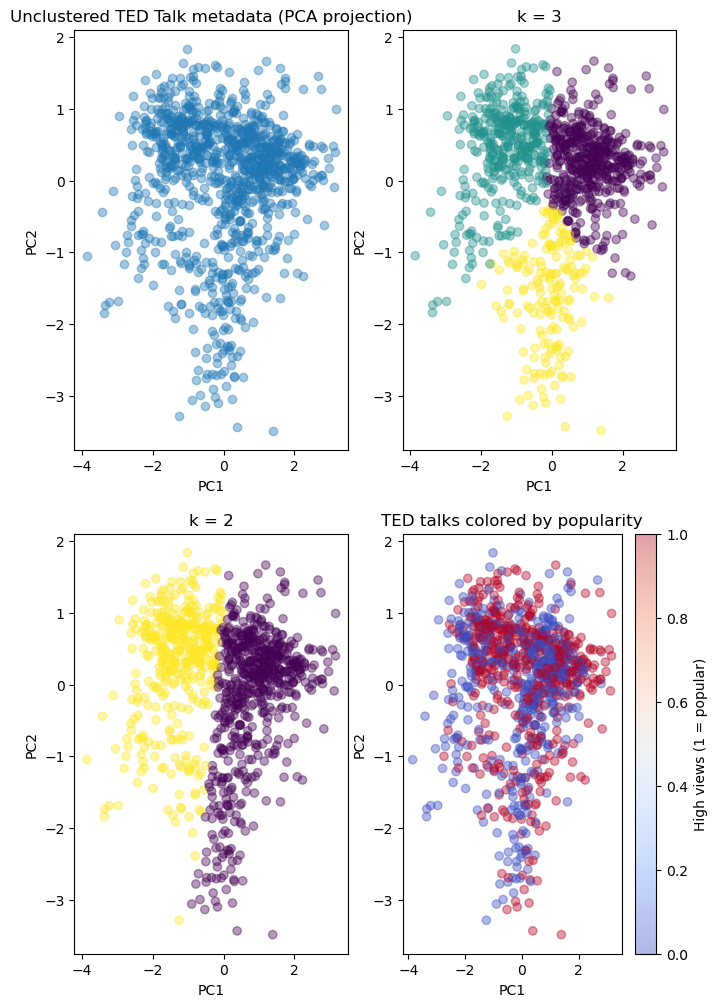

In [53]:
features = [
    "log_comments",
    "log_duration",
    "recorded_year"
]

X = df[features]
X_scaled = StandardScaler().fit_transform(X)

X_2d = PCA(n_components = 2, random_state = 42).fit_transform(X_scaled)

plt.figure(figsize=(12, 12))

# Unclustered data
plt.subplot(231)
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha = 0.4)
plt.title("Unclustered TED Talk metadata (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# 3 clusters!
y_pred3 = KMeans(
    n_clusters = 3,
    random_state = 42,
    n_init=10
).fit_predict(X_scaled)

plt.subplot(232)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c = y_pred3, alpha = 0.4)
plt.title("k = 3")
plt.xlabel("PC1")
plt.ylabel("PC2")
df["cluster3"] = y_pred3


# 2 Clusters!
y_pred2 = KMeans(
    n_clusters = 2,
    random_state = 42,
    n_init = 10
).fit_predict(X_scaled)

plt.subplot(234)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c = y_pred2, alpha = 0.4)
plt.title("k = 2")
plt.xlabel("PC1")
plt.ylabel("PC2")
df["cluster2"] = y_pred2

# plotting the popular and unpopular diff
plt.subplot(235)
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c = df["high_views"],
    cmap = "coolwarm",
    alpha = 0.4
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("TED talks colored by popularity")
plt.colorbar(label="High views (1 = popular)")
plt.show()


Here, we can see that our K-Means algorithm, when given the selected non-text features, has pretty split our speeches into pretty distinct, minimally overlapping clusters. There is some, but not much overlap between the clusters in both clusterings. However, when we compare it to the last figure, which clusters the talks by popularity, we can see that neither of the clusterings naturally reflect that of the popularity cluster. This tells us, that there are other stronger patterns that the K-Means is picking up on, and these patterns are not necessarily that of popularity. The clustering is instead capturing more structural patterns in engagement, year, and duration, that might be related to, but is not determined by, popularity.

In [54]:
df.groupby("cluster3")[["log_comments", "log_duration", "recorded_year"]].describe()

log_comments                                                    \
                count      mean       std       min       25%       50%   
cluster3                                                                  
0               457.0  5.133157  0.834091  2.564949  4.564348  5.093750   
1               370.0  3.336972  0.821822  0.693147  2.708050  3.401197   
2               173.0  4.825581  0.702591  2.833213  4.406719  4.875197   

                             log_duration            ...                      \
               75%       max        count      mean  ...       75%       max   
cluster3                                             ...                       
0         5.645447  8.138857        457.0  6.868478  ...  7.013016  7.706613   
1         3.891820  5.455321        370.0  6.532872  ...  6.742586  7.195187   
2         5.283204  6.760415        173.0  5.885389  ...  6.154858  6.411818   

         recorded_year                                                         \
                 count         mean       std     min     25%     50%     75%   
cluster3                                                                        
0                457.0  2010.291028  3.335841  2002.0  2008.0  2011.0  2013.0   
1                370.0  2017.370270  1.476347  2012.0  2017.0  2017.0  2019.0   
2                173.0  2011.497110  2.518823  2005.0  2009.0  2011.0  2013.0   

                  
             max  
cluster3          
0         2017.0  
1         2020.0  
2         2018.0  

[3 rows x 24 columns]

In [55]:
df.groupby("cluster2")[["log_comments", "log_duration", "recorded_year"]].describe()

log_comments                                                    \
                count      mean       std       min       25%       50%   
cluster2                                                                  
0               598.0  5.102946  0.790303  2.564949  4.564348  5.072039   
1               402.0  3.392528  0.820653  0.693147  2.772589  3.496508   

                             log_duration            ...                      \
               75%       max        count      mean  ...       75%       max   
cluster2                                             ...                       
0         5.575000  8.138857        598.0  6.642793  ...  6.977981  7.706613   
1         3.960675  5.455321        402.0  6.472236  ...  6.729525  7.195187   

         recorded_year                                                         \
                 count         mean       std     min     25%     50%     75%   
cluster2                                                                        
0                598.0  2010.431438  3.109581  2002.0  2009.0  2011.0  2013.0   
1                402.0  2017.116915  1.765212  2007.0  2016.0  2017.0  2018.0   

                  
             max  
cluster2          
0         2017.0  
1         2020.0  

[2 rows x 24 columns]

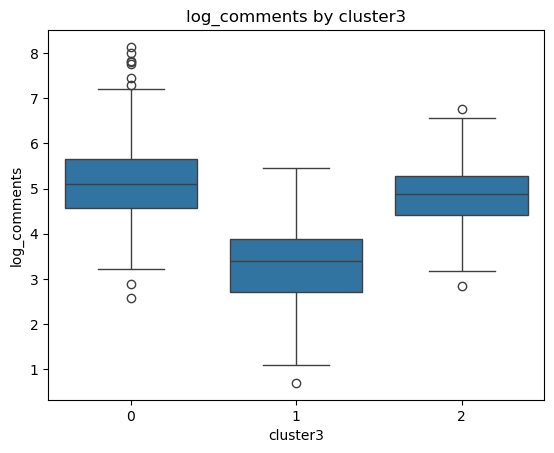

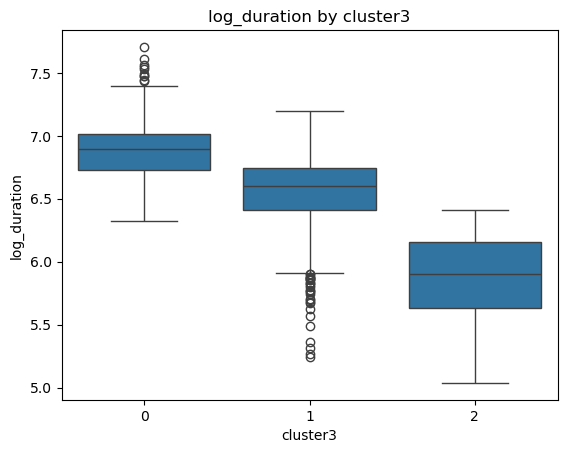

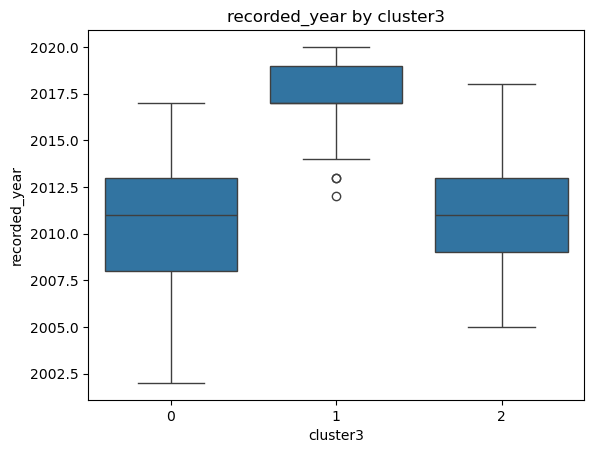

In [56]:
#box plot visualization of results for 3 clusters
for col in ["log_comments", "log_duration", "recorded_year"]:
    sns.boxplot(x="cluster3", y=col, data=df)
    plt.title(f"{col} by cluster3")
    plt.show()

We can see through these results as well that our clustering was able to capture some structural patterns among our data when k = 3. 

# Logistic Regression

Now, we will utilize logistic regression to see how well our features can predict popularity. We start with testing them individually to see if any feature significantly outperforms the rest in prediction. Then, we combine the features to see how well they perform when interacting with each other to predict popularity.

In [57]:
#we dropped the first column here to avoid multi colinearity
X_categorical = pd.get_dummies(
    df[["occupation_clean"]],
    drop_first=True
)

X_num = df[["log_comments", "log_duration", "recorded_year"]]

X = pd.concat([X_num, X_categorical], axis=1)
y = df["high_views"]

#scaling the features so they all contribute and are weighted fairly
scaler = StandardScaler()
X[X_num.columns] = scaler.fit_transform(X[X_num.columns])

In [58]:
X_comments = df[["log_comments"]].copy()

scaler = StandardScaler()
X_comments["log_comments"] = scaler.fit_transform(X_comments)

logit_comments = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1_comments = cross_val_score(
    logit_comments,
    X_comments,
    y,
    scoring="f1",
    cv=5
)

print("log_comments mean F1:", f1_comments.mean())


log_comments mean F1: 0.5897645530978995


In [59]:
X_duration = df[["log_duration"]].copy()

scaler = StandardScaler()
X_duration["log_duration"] = scaler.fit_transform(X_duration)

logit_duration = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1_duration = cross_val_score(
    logit_duration,
    X_duration,
    y,
    scoring="f1",
    cv=5
)

print("log duration mean F1:", f1_duration.mean())

log duration mean F1: 0.5776251599581153


In [60]:
X_year = df[["recorded_year"]].copy()

scaler = StandardScaler()
X_year["recorded_year"] = scaler.fit_transform(X_year)

logit_year = LogisticRegression(
    max_iter = 1000,
    class_weight = "balanced",
    random_state = 42
)

f1_year = cross_val_score(
    logit_year,
    X_year,
    y,
    scoring = "f1",
    cv = 5
)

print("log recorded year mean F1:", f1_year.mean())

log recorded year mean F1: 0.5880649425103603


In [61]:
single_feature_results = pd.DataFrame({
    "Feature": ["log_comments", "log_duration", "recorded_year"],
    "Mean F1 (CV)": [
        f1_comments.mean(),
        f1_duration.mean(),
        f1_year.mean()
    ]
})

single_feature_results

,Feature,Mean F1 (CV)
0,log_comments,0.589765
1,log_duration,0.577625
2,recorded_year,0.588065


From these results, we can see that the comment count independently provides a strong predictive signal. And the duration and recorded year are also close as well. When we look at occupation only, it is a bit weaker than comments, duration, and recorded year. Overall however, we can see that none of these results are very strong, with none of them even reaching 0.6. With values aroudn 0.58, this tells us that when using these features independently to predict popularity, they are only slightly better than randomly guessing with 50% chance of it being popular and 50% chance of it being unpopular.

In [ ]:
X_occupation = pd.get_dummies(df[["occupation_clean"]], drop_first=True)

clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1_occ = cross_val_score(
    clf,
    X_occupation,
    y,
    scoring="f1",
    cv=5
)

print("Occupation-only Mean F1:", f1_occ.mean())


Occupation-only F1: 0.43806067983005204


Then when looking at the F1 value of only factoring in occupation, it performs worse than just randomly guessing. This tells us that using occupation alone most likely won't be very helpful in determining whether or not a TED Talk is going to be popular. So now, we will combine all of these features to see how well they can perform together when predicting popularity. 

In [63]:
#logistic regression process as used in lecture 5
logit_clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1 = cross_val_score(
    logit_clf,
    X,
    y,
    scoring = "f1",
    cv = 5
)

print("Mean logit, crossvalidated, f1:", f1.mean())

logit_clf.fit(X, y)
y_logit = logit_clf.predict(X)
coef_df = (
    pd.DataFrame({
        "feature": X.columns,
        "coef": logit_clf.coef_[0]
    })
    .sort_values(by="coef", ascending=False)
)
coef_df.head(15)

Mean logit, crossvalidated, f1: 0.710672763091532


,feature,coef
0,log_comments,1.345930
2,recorded_year,1.247797
8,occupation_clean_{0: ['author']},1.182201
9,occupation_clean_{0: ['behavioral economist']},0.681135
20,occupation_clean_{0: ['neuroscientist']},0.519503
21,occupation_clean_{0: ['philosopher']},0.461141
10,occupation_clean_{0: ['biologist']},0.460152
4,occupation_clean_{0: ['architect']},0.380554
13,occupation_clean_{0: ['economist']},0.367574
25,occupation_clean_{0: ['surgeon']},0.155709


This tells us that across 5 different training and testing splits, the logistic regression model that we created was able to come to an average F1 score of around 0.71 when trying to predict whether a talk was popular or not popular.

C:\Users\Kyleena Xin\AppData\Local\Temp\ipykernel_50192\2278445152.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = top_feats["coef"], y = top_feats["feature"], palette = 'Paired')


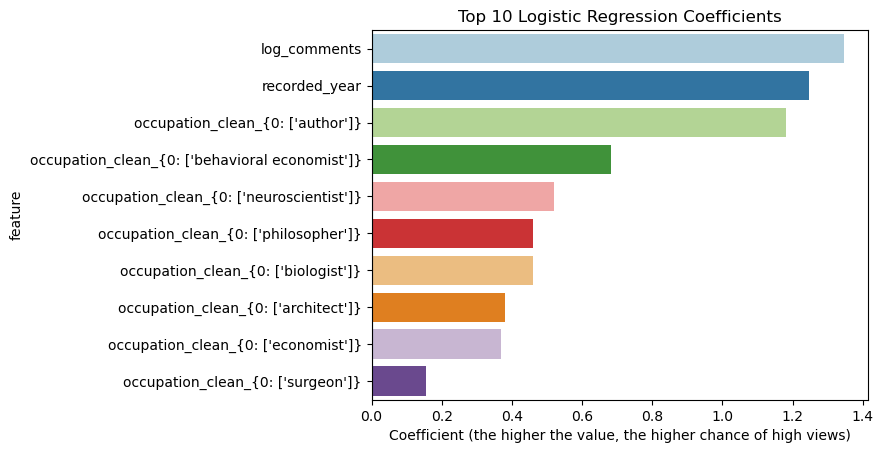

In [64]:
top_feats = coef_df.head(10)

sns.barplot(x = top_feats["coef"], y = top_feats["feature"], palette = 'Paired')
plt.axvline(0)
plt.title("Top 10 Logistic Regression Coefficients")
plt.xlabel("Coefficient (the higher the value, the higher chance of high views)")
plt.show()

This bar plot shows the top 10 features that had the highest logistic regression coefficients. Each coefficient represents how much a given feature is pushing the model toward predicting "high views" versus "low views," while holding all of the other features constant (lecture 5). As we can see here, the features that were engagement-related such as the comments was the strongest predictive signal, and the second highest logistic coefficient came from recorded year, followed by all of the occupation data. Talks by authors and behavioral economists were the most likely to be popular out of all of the occupations. There are coefficients here greater than 1 because logistic regression operates in log-odds space, and do not correspond directly to probabilities.

# Textual Analysis: Logistic Regression

We frame the TED Talks as a classification problem using predictive modeling with a logistic regression classifier. We split our training data into a training and test set using sklearn's `train_test_split` function, making the test set 30% of the sample. We track the index of every item across the sets. We then train a logistic regression classifier on vectorized transcripts of the training set and evaluate on the test set. Note we use a CountVectorizer here, rather than the TFIDF vectorizer used for our topic analysis.

In [65]:
X = df["transcript"].to_list()
y = df["high_views"].to_list()
indices = df.index.tolist()

train_idx, test_idx, X_train, X_test, y_train, y_test = train_test_split(indices, X, y, test_size=0.3, random_state=42)

In [66]:
count_vectorizer = CountVectorizer()
X_train_vec = count_vectorizer.fit_transform(X_train)
X_test_vec = count_vectorizer.transform(X_test)

lrc = LogisticRegression(max_iter=1000, random_state = 42).fit(X_train_vec, y_train)

y_pred = lrc.predict(X_test_vec)

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       152
           1       0.62      0.61      0.61       148

    accuracy                           0.62       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.62      0.62      0.62       300



Just as we did for non-textual findings, we can find the top 20 words (features) based on the coefficients used by our logistic regression classifier.

In [68]:
# get top 20 coefficients for lrc
feature_names = count_vectorizer.get_feature_names_out()

text_coef_df = pd.DataFrame({
    "word": feature_names,
    "coef": lrc.coef_[0][:len(feature_names)]
}).sort_values("coef", ascending=False)

text_coef_df.head(20)


,word,coef
1958,applause,0.347908
11315,first,0.282655
1870,any,0.266254
12412,get,0.242948
12654,good,0.240600
5355,china,0.236853
19215,music,0.232997
25392,same,0.222040
32546,your,0.221500
10375,even,0.220985


C:\Users\Kyleena Xin\AppData\Local\Temp\ipykernel_50192\2176479045.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = text_top_feats["coef"], y = text_top_feats["word"], palette = 'Paired')


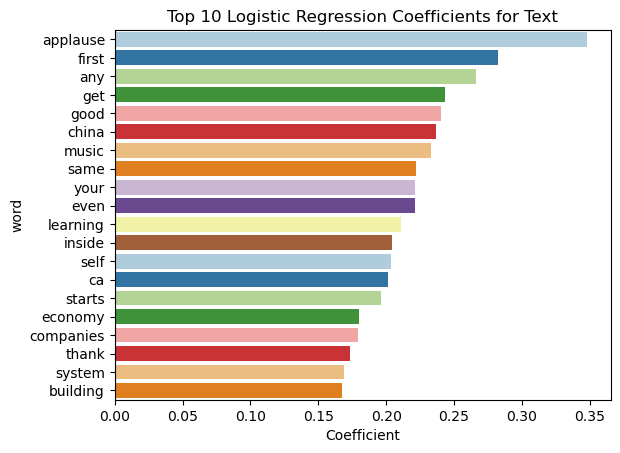

In [69]:
# display coefficients as bar chart
text_top_feats = text_coef_df.head(20)

sns.barplot(x = text_top_feats["coef"], y = text_top_feats["word"], palette = 'Paired')
plt.axvline(0)
plt.title("Top 10 Logistic Regression Coefficients for Text")
plt.xlabel("Coefficient")
plt.show()

# Feature & Topic Analysis

In [70]:
data = pd.read_csv("data/tedtalk_sample.csv")

Shape of Feature Matrix: (1000, 7008)


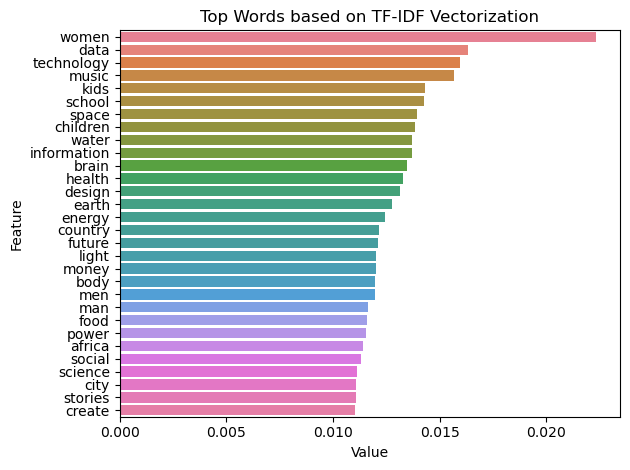

In [71]:
#Vectorizer

vectorizer = TfidfVectorizer(
    input = "content",
    encoding = "utf-8",
    stop_words = "english",
    strip_accents= "unicode",
    min_df= 10,
    max_df = 0.4,
    norm = 'l2',
    use_idf=True
)

#fit vectorizer onto corpus
data_vectorized = vectorizer.fit_transform(data['transcript'])
print(f"Shape of Feature Matrix: {data_vectorized.shape}")

#store feature names + values
feature_name = vectorizer.get_feature_names_out()
val = data_vectorized.mean(axis = 0).A1

top_features = pd.DataFrame({
    "feature": feature_name,
    "value": val
}).sort_values("value", ascending = False).head(30)

sns.barplot(y = top_features["feature"], 
            x = top_features["value"], 
            hue = top_features["feature"], 
            legend = False,
            width = 0.8)
plt.title("Top Words based on TF-IDF Vectorization")
plt.ylabel("Feature")
plt.xlabel("Value")
plt.tight_layout()
plt.show()


In [72]:
#utilized from lecture 09
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

#utilized from hw2
def display_topics(model, feature_names, k_top_words, title, n_topics=10):

    fig, axes = plt.subplots(round(n_topics/7), 7, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    color_palette = plt.cm.viridis(np.linspace(0.3, 0.9, k_top_words))


    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-k_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color = color_palette)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)

        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    
    
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()

Topic  0: library lunch gun films statistics poem lady fiction characters jim
Topic  1: music slavery baltimore radar bat invasive adulthood unsafe hooked zealand
Topic  2: cities robot carbon robots democracy development europe institutions governments citizens
Topic  3: women data technology kids school space children water information brain
Topic  4: music ends starts welfare distorted zone zip zero zealand youtube
Topic  5: slums bg grandma transmission comedy hindu patent transaction affair corrupt
Topic  6: mars microbes genome molecules trial vaccines printing spacecraft molecular proteins



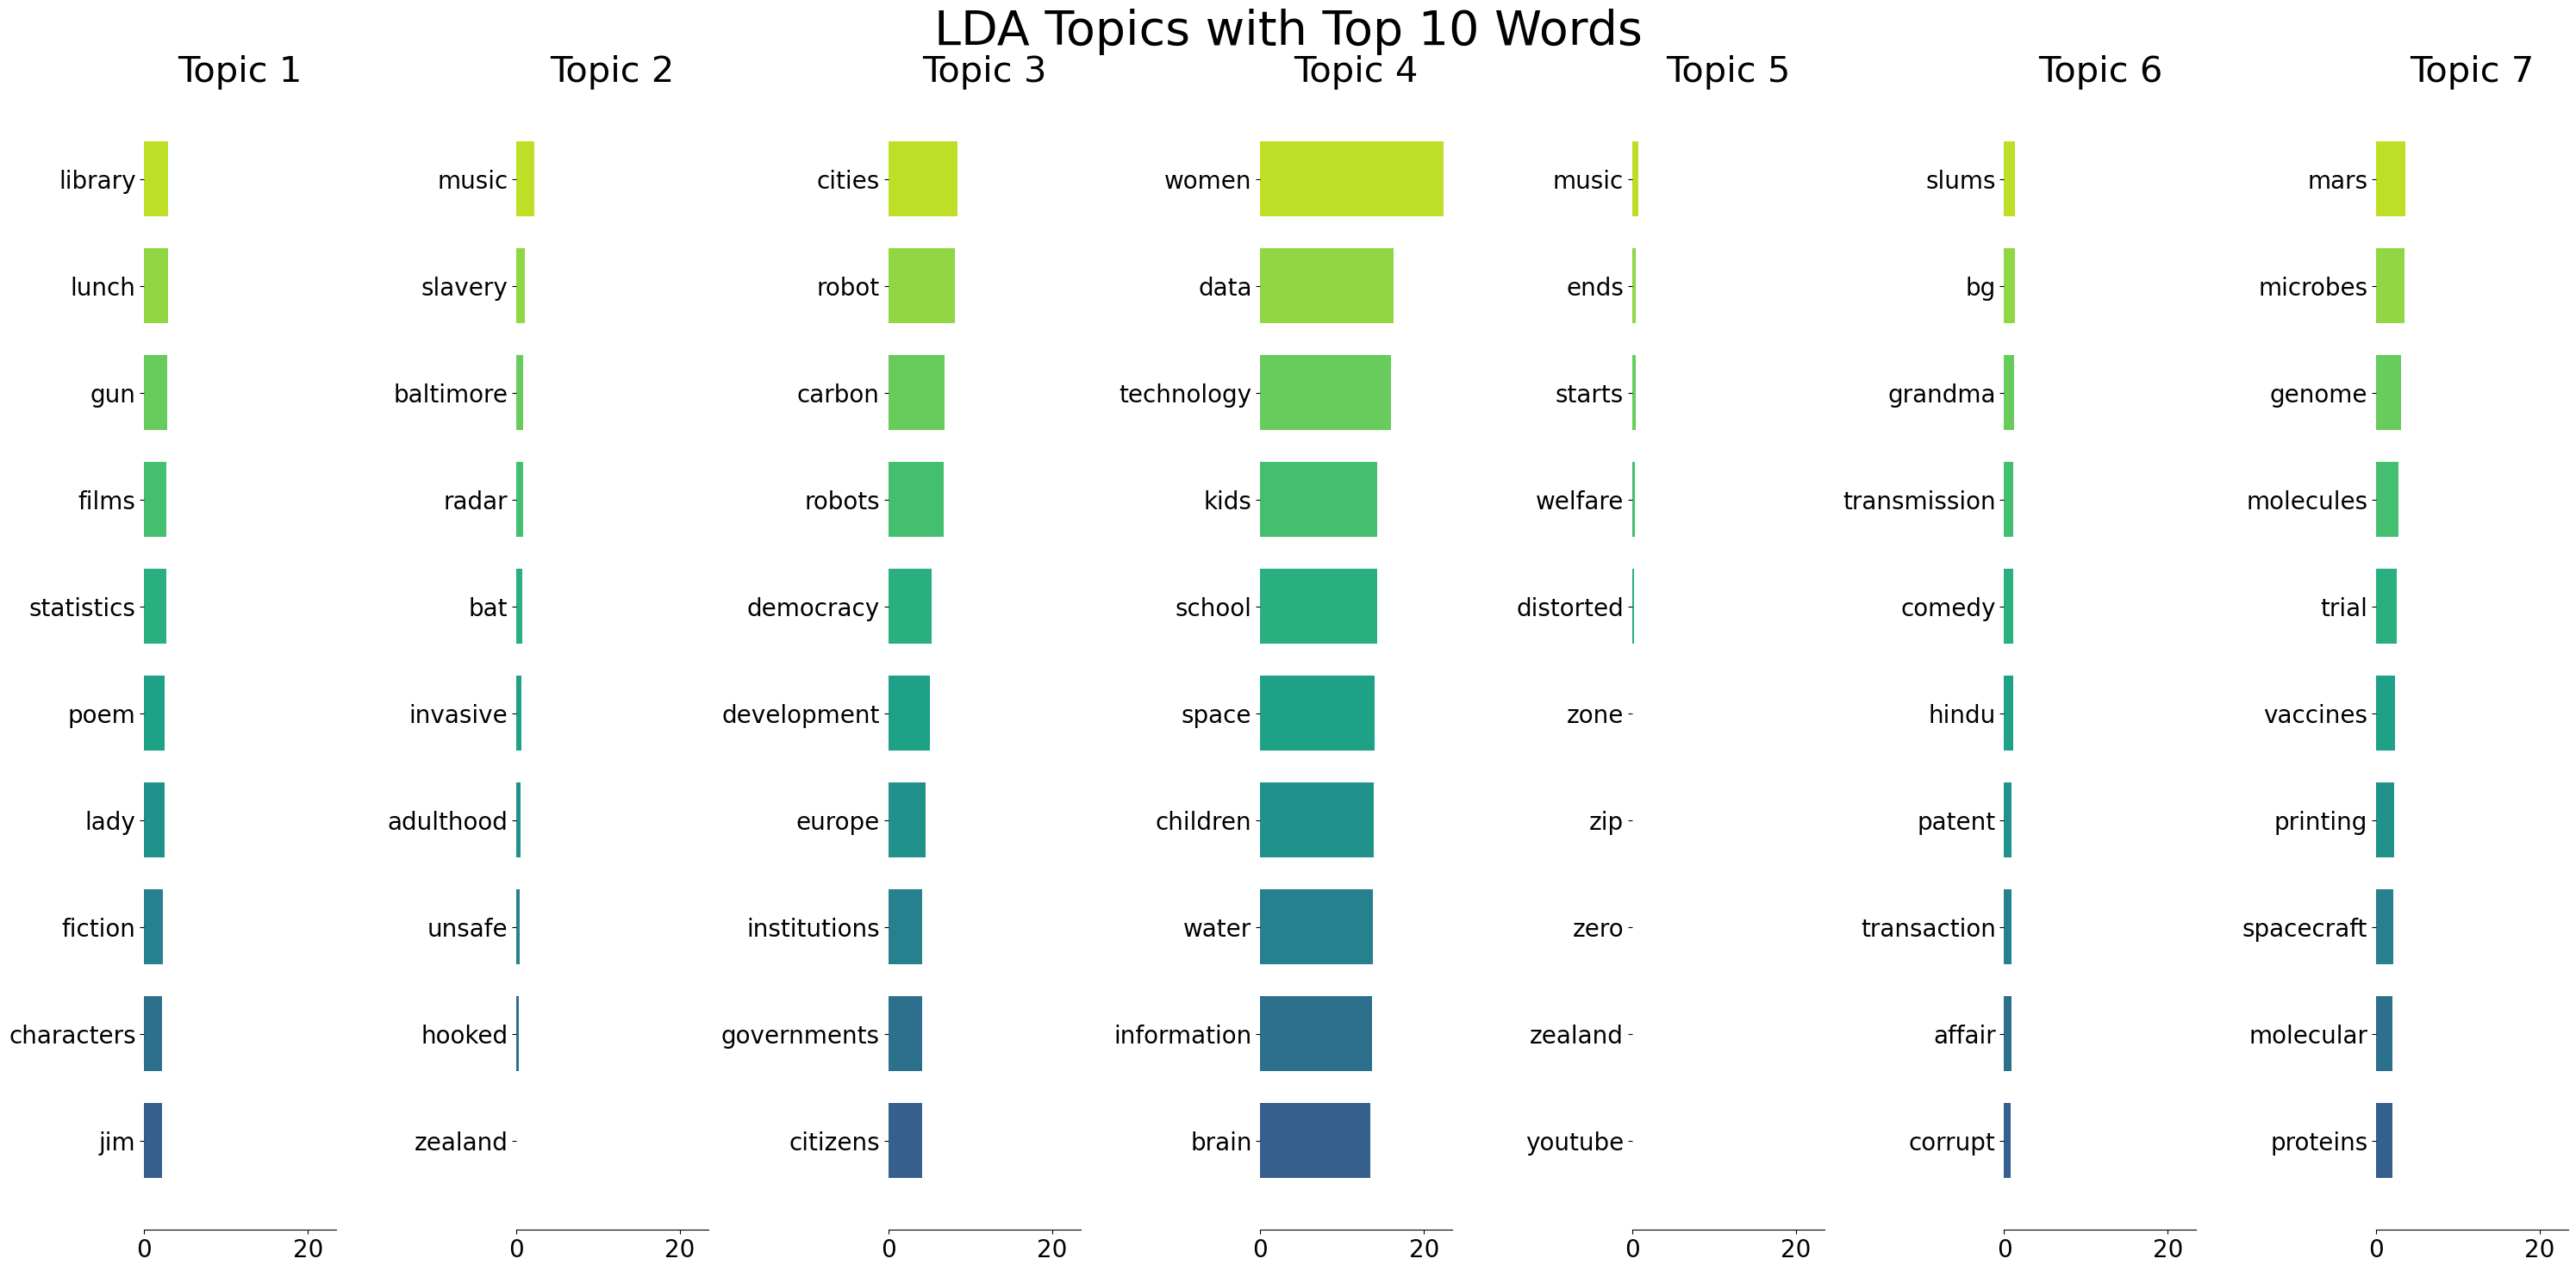

In [73]:
#LDA
lda = LatentDirichletAllocation(
    n_components= 7,
    n_jobs=-1,
    max_iter= 50,
    learning_method= 'batch',
    doc_topic_prior= 0.1,
    topic_word_prior= 0.01,
    evaluate_every=0,
    random_state=42
)

lda.fit(data_vectorized)

print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

display_topics(lda, vectorizer.get_feature_names_out(), k_top_words=10, title = "LDA Topics with Top 10 Words", 
               n_topics=7)

Topic  0: kids school children book students parents stories child man sort
Topic  1: women men woman girls gender sex female man sexual girl
Topic  2: africa cities countries country global energy city dollars money climate
Topic  3: earth planet ocean space light species water universe solar planets
Topic  4: cancer patients cells brain health patient medical care disease data
Topic  5: music sound piece play ends musical sounds voice drum singing
Topic  6: robot robots computer technology ai machine design machines robotic video



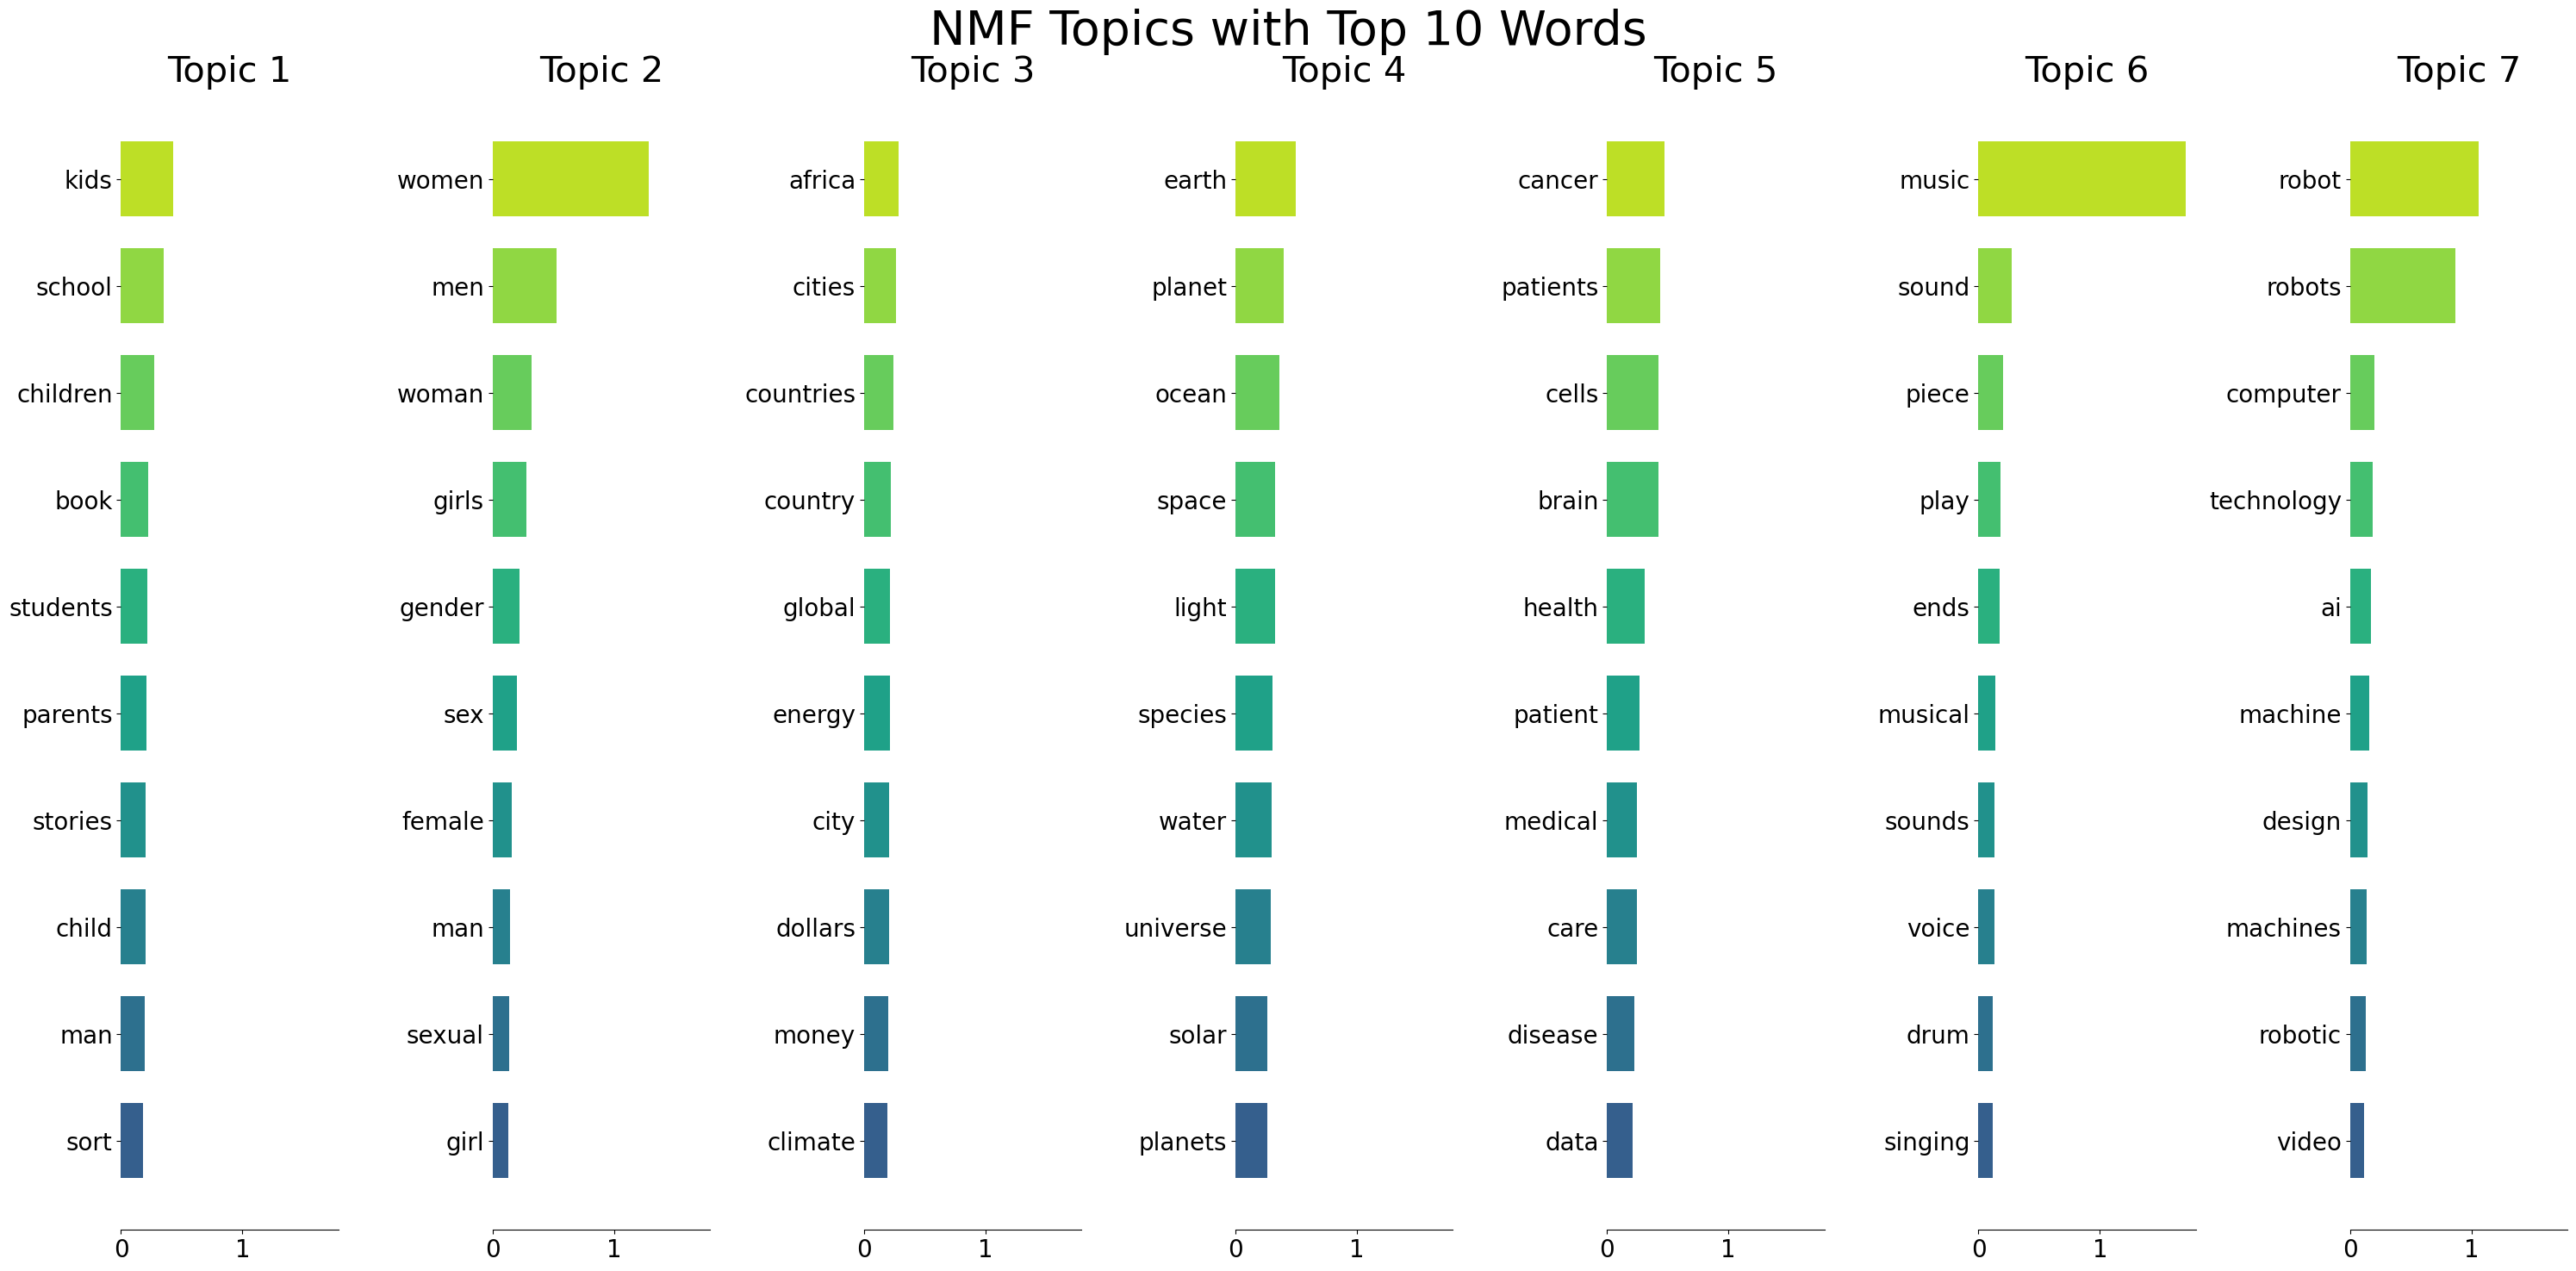

In [74]:
#initialize NMF
nmf = NMF(
    n_components= 7,
    init='nndsvd',
    random_state=42
)

#fit NMF and extract components + feature names
nmf_fit = nmf.fit_transform(data_vectorized)
nmf_components = nmf.components_  
feature_names = vectorizer.get_feature_names_out()

#use print func to see topic categories
print_top_words(
    model=nmf,
    feature_names= vectorizer.get_feature_names_out(),
    n_top_words=10
)

display_topics(nmf, vectorizer.get_feature_names_out(), k_top_words=10, title = "NMF Topics with Top 10 Words", 
               n_topics=7)

# Prompting and Generation

We use an LLM for few-shot prompting to classify a few of our TEDTalks into "Popular" and "Not Popular." 

In [75]:
# small model
ollama_model_name = "gemma3:1b-it-qat"

In [76]:
# from problem set 4

class OllamaChatModel:
    def __init__(self, 
                 model_name: Optional[str] = None,
                 base_url: str = "http://localhost:11434/v1"):
        """
        Args:
            model_name: Name of a model that is accessible via Ollama.
                            Optional string.
            base_url:   String of the Url of your Ollama server. 
        """
        self.client = OpenAI(
            base_url=base_url,
            api_key="ollama"
        )
        self.model_name = model_name

    def __call__(self, 
                 prompt: str, 
                 model_name: Optional[str] = None, 
                 **kwargs) -> str:
        """
        Args:
            prompt:     Prompt to pass to the model. String.
            model_name: Name of a model that is accessible via Ollama.
                            If None, defaults to self.model_name. Optional string.
            kwargs:     Kwargs are passed directly to the OpenAI client's 
                            chat.completions.create method.
        Returns:a
            response:   The model's response to the prompt as a string.
        """
        assert any((model_name, self.model_name)), "Please specify a model to use."
        if not model_name: 
            model_name = self.model_name
        
        response = self.client.chat.completions.create(
            model=model_name,
            messages=[
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            **kwargs
        )
        response = response.choices[0].message.content
        return response

In [77]:
# from problem set 4, create builder for few-shot learning

class FewShotPromptBuilder:
    """
    Class for building a few-shot LLM prompt.
    """
    def __init__(self, 
                 prompt_template: str, 
                 example_template: str,
                 example_data: Sequence[Sequence]):
        """
        Args:
            prompt_template:  A string with, at minimum, an {examples} replacement field.
            example_template: A string with numbered replacement fields ({0}, {1}, ...) 
                                that correspond to each item in a single example from example_data. 
            example_data:     A Sequence of equal-length Sequences containing example data (e.g. text/label pairs)
        """
        self.prompt_fields = set(self.extract_fields(prompt_template))
        assert "examples" in self.prompt_fields, \
            "prompt_template must include an {examples} replacement field"
        self.prompt_template = prompt_template 

        self.validate_example_data(example_data)
        self.example_data = example_data
        self.num_examples = len(example_data)
        self.example_length = len(example_data[0])

        self.validate_example_template(example_template)
        self.example_template = example_template
    
    def __call__(self, n: int, random=False, **kwargs) -> str:
        """
        Builds a prompt with n examples. 
        
        Args: 
            n:        Number of examples from self.example_data to sample. 
            random:   Whether to sample the examples randomly or not. If False (default), take the first 
                        n examples in self.example_data.
            kwargs:   Any additional replacement fields and their values for formatting the prompt template.
        Returns:
            prompt:   Correctly formatted prompt containing n examples.

        """
        assert n <= self.num_examples, \
            f"{n} is greater than the total number of examples ({self.num_examples})."

        assert all([k in self.prompt_fields for k in kwargs]), \
            "Mismatch between kwargs and replacement fields in prompt_template."

        if random:
            examples = random.sample(self.example_data, n)
        else:
            examples = self.example_data[:n]

        formatted_examples = self.format_examples(examples) # uses following method

        prompt = self.prompt_template.format(examples=formatted_examples, **kwargs)

        return prompt

    def format_examples(self, sampled_examples: Sequence[Sequence]) -> str:
        """
        Formats examples with self.example_template.

        Args:
            sampled_examples:   Nested sequence of examples for formatting.
        Returns: 
            formatted_examples: Examples formatted with self.example_template. String.
        """
        # TODO
        # Your code here
        formatted_examples = []
        for example in sampled_examples:
            formatted_examples.append(self.example_template.format(*example))

        return "\n".join(formatted_examples)
         
    def validate_example_data(self, example_data: Sequence[Sequence]):
        """
        Ensures example data is composed of equal-length subsequences.
        """
        length = len(example_data[0])
        for i, example in enumerate(example_data):
            assert len(example) == length, \
                f"example_data contains sequences of unequal length: " \
                f"Expected length {length} but found {len(example)} at index {i}"

    def validate_example_template(self, example_template: str):
        """
        Ensures examples are valid. 
        """
        example_template_fields = [int(i) for i in self.extract_fields(example_template)]
        if len(example_template_fields) > 1: 
            assert all(
                [
                    max(*example_template_fields) == self.example_length - 1,
                    len(example_template_fields) == self.example_length,
                    set(example_template_fields) == set(range(self.example_length))
                ]
            ), "example_template's replacement fields do not match samples in example_data."
        else:
            assert example_template_fields[0] == 0, \
                "example_template should contain {0} if examples contain only a single sample."

    @staticmethod
    def extract_fields(template: str) -> Sequence: 
        """Extracts replacement fields from a template."""
        pattern = re.compile(r"\{(\w+)}")
        return re.findall(pattern, template)

    def __repr__(self) -> str:
        kwargs = {k: f"{{{k}}}" for k in self.prompt_fields if k != "examples"}

        return f"FewShotPrompt containing {self.num_examples} examples, each with {self.example_length} values.\n\n"\
               f"Sample formatted prompt using first example:\n******\n{self(1, **kwargs)}"
               

In [78]:
# curate examples for few-shot, adapted from PS 4

label_output_map = {
    1: "POPULAR",
    0: "NOT POPULAR"
}

output_label_map = {
    "popular": 1,
    "not popular": 0
}

# pick 5 popular and 5 not popular talks
popular = np.argwhere(np.array(y_train) == 1).squeeze()[:5]
not_popular = np.argwhere(np.array(y_train) == 0).squeeze()[:5]

balanced_idx = np.concatenate((popular, not_popular))

example_labels = np.concatenate((
    np.ones(5),
    np.zeros(5)
)).astype(int)

# shuffle
shuffle_idx = np.random.permutation(len(balanced_idx))
balanced_idx = balanced_idx[shuffle_idx].tolist()
example_labels = example_labels[shuffle_idx].tolist()

# extract example texts
balanced_examples = [X_train[i] for i in balanced_idx]

ted_example_data = [
    (text, label_output_map[label])
    for text, label in zip(balanced_examples, example_labels)
]

In [79]:
# detailed prompt
few_shot_prompt = "Your task is to classify a TED TALK presentation based" \
                  "on its popularity, given the two available OPTIONS of " \
                  "'POPULAR' or 'NOT POPULAR'. Your response should be limited " \
                  "to only one of the available OPTIONS.\n" \
                  "***\n" \
                  "EXAMPLE:\n" \
                  "{examples}" \
                  "***\n" \
                  "TED TALK: {item}\n" \
                  "OPTIONS: {classes}\n" \
                  "Given the above, which category in OPTIONS best describes the TEDTALK? " \
                  "Respond with only one of the two OPTIONS, which are 'POPULAR' or 'NOT POPULAR'."


few_shot_example_template = (
    "TED TALK: \n{0}\n"
    "LABEL: {1}\n"
)

few_shot_builder = FewShotPromptBuilder(
    prompt_template=few_shot_prompt,
    example_template=few_shot_example_template,
    example_data=ted_example_data
)

print(few_shot_builder)

FewShotPrompt containing 10 examples, each with 2 values.

Sample formatted prompt using first example:
******
Your task is to classify a TED TALK presentation basedon its popularity, given the two available OPTIONS of 'POPULAR' or 'NOT POPULAR'. Your response should be limited to only one of the available OPTIONS.
***
EXAMPLE:
TED TALK: 
I thought if I skipped it might help my nerves, but I'm actually having a paradoxical reaction to that, so that was a bad idea. (Laughter) Anyway, I was really delighted to receive the invitation to present to you some of my music and some of my work as a composer, presumably because it appeals to my well-known and abundant narcissism. (Laughter) And I'm not kidding, I just think we should just say that and move forward. (Laughter) So, but the thing is, a dilemma quickly arose, and that is that I'm really bored with music, and I'm really bored with the role of the composer, and so I decided to put that idea, boredom, as the focus of my presentation to

In [80]:
# adapted from PS 4

def llm_classify_few_shot(model: OllamaChatModel, 
                          X: Sequence[str],
                          prompt_builder: FewShotPromptBuilder, 
                          output_label_map: dict,
                          num_examples: int = 5,
                          sample_random: bool = False) -> Tuple[Sequence[int], Sequence[int]]:
    """
    Args:
        model:            An OllamaChatModel. 
        X:                A sequence of strings with length N.
        prompt_builder:   A FewShotPromptBuilder.
        output_label_map: Dict with {output: integer_label}.
        num_examples:     Number of examples to sample with the FewShotPromptBuilder. 
        sample_random:    Whether to sample randomly with the FewShotPromptBuilder. Default is False.
    Returns:
        preds:            Sequence of integer class predictions with length N. (1 for popular, 0 for not popular, -1 for invalid)
        valids:           Sequence of validity values (0 for invalid output, 1 for valid) with length N. 
    """
    preds = []
    valids = []

    valid_outputs = list(output_label_map.keys())

    for ted_talk in X:
        prompt = prompt_builder(
            num_examples,
            random=sample_random,
            item=ted_talk,
            classes=", ".join(valid_outputs)
        )

        response = model(prompt, temperature=0.0).strip().lower()

        is_valid = int(response in output_label_map)
        valids.append(is_valid)

        if is_valid:
            preds.append(output_label_map[response])
        else:
            preds.append(-1)

    return preds, valids

In [81]:
ollama_model = OllamaChatModel(ollama_model_name)

N = 50 # use only 50 for runtime

few_shot_preds, few_shot_valids = llm_classify_few_shot(
    model=ollama_model,
    X=X_test[:N],
    prompt_builder=few_shot_builder,
    output_label_map=output_label_map,
    num_examples=3,
    sample_random=False
)

report = classification_report(
    y_test[:N],
    few_shot_preds,
    output_dict=True,
    zero_division=0
)

validity_score = sum(few_shot_valids) / len(few_shot_valids)

# filter out the invalid -1 responses to generate a report
valid_idx = np.array(few_shot_valids) == 1

filtered_y_true = np.array(y_test[:N])[valid_idx]
filtered_y_pred = np.array(few_shot_preds)[valid_idx]

report = classification_report(
    filtered_y_true,
    filtered_y_pred,
    zero_division=0
)

print(report)


              precision    recall  f1-score   support

           0       0.45      0.45      0.45        20
           1       0.39      0.39      0.39        18

    accuracy                           0.42        38
   macro avg       0.42      0.42      0.42        38
weighted avg       0.42      0.42      0.42        38



Next, we aim to generate both popular and unpopular TED Talks using the same few-shot builder. We use the logistic regression classifier from above to observe how they are classified.

In [82]:
# detailed template
prompt_template = "You are a TED Talk speaker who delivers successful, " \
                  "well-received presentations. Your TED talks are inspiring " \
                  "and gain many views, using language appealing to various " \
                  "audiences. You will be provided with example transcripts of " \
                  "TED Talks. Your task is to write a transcript for a clear, " \
                  "engaging talk, imitating the style of the example transcripts "  \
                  "you have seen." \
                  "Examples:\n{examples}\n" \
                  "Write a new TED Talk transcript, imitating the style of the examples above. " \
                  "Respond with only the transcript and no other text.\n"


example_template = (
    "TED TALK:\n{0}\n"
)

# example transcripts
popular_talks = [X_train[i] for i, y in enumerate(y_train) if y == 1]
unpopular_talks = [X_train[i] for i, y in enumerate(y_train) if y == 0]

popular_example_data = [(t,) for t in popular_talks]
unpopular_example_data = [(t,) for t in unpopular_talks]

In [83]:
# intialize builders

popular_prompt_builder = FewShotPromptBuilder(
    prompt_template=prompt_template,
    example_template=example_template,
    example_data=popular_example_data
)

unpopular_prompt_builder = FewShotPromptBuilder(
    prompt_template=prompt_template,
    example_template=example_template,
    example_data=unpopular_example_data
)

In [84]:
def generate_talks(model: OllamaChatModel, 
                   prompt_builder: FewShotPromptBuilder, 
                   num_talks: int, 
                   num_examples: int, 
                   random_sample: bool = False):

    talks = []
    for _ in range(num_talks):
        prompt = prompt_builder(n=num_examples, random=random_sample)
        talk = model(prompt).strip()
        talks.append(talk)
    return talks


In [85]:
# generate talks

generated_popular = generate_talks(
    model=ollama_model,
    prompt_builder=popular_prompt_builder,
    num_talks=2,
    num_examples=3
)

generated_unpopular = generate_talks(
    model=ollama_model,
    prompt_builder=unpopular_prompt_builder,
    num_talks=2,
    num_examples=3
)

In [89]:
# print popular talks
print("Popular talks: ")
for i, talk in enumerate(generated_popular):
    print(f"Talk {i+1}:\n{talk}\n\n")

Popular talks: 
Talk 1:
Okay, here’s a TED Talk transcript mimicking the style of the provided examples.

**TED Talk Transcript: The Quiet Strength of Regret**

(Start with a slightly reflective, ambient music bed - perhaps piano or nature sounds)

“Hello, everyone. It’s funny, we spend so much time striving for ‘happiness,’ for a life of ease and fulfillment. We talk about ‘growth,’ about ‘making it happen.’ And those are great goals, of course. But today, I want to talk about something quieter, something more profound: regret. Not the dramatic, messy kind, but the subtle, persistent feeling. The quiet recognition that something *could* have been different.  For years, I've been chasing the idea of perfect, of having it all figured out. I was terrified of making mistakes, of not being good enough. And lately, I’ve been noticing a pattern: a creeping sense of feeling… incomplete. It's a sense that I could have *done* something else, *said* something else, *felt* something else. Not a g

In [90]:
# print unpopular talks
print("Not popular talks: ")
for i, talk in enumerate(generated_unpopular):
    print(f"Talk {i+1}:\n{talk}\n\n")

Not popular talks: 
Talk 1:
Kdv. 

**(Intro – light, minimalist music)**

Good morning everyone. It’s amazing to be here, sharing something I’ve been wrestling with for a long time – storytelling.  It's not about grand narratives or perfectly constructed plots. It’s about how silence, vulnerability, and the uncomfortable acceptance of contradiction actually *build* the stories we tell, and, ultimately, the stories *we* are.

We’re bombarded with stories – blockbuster movies, glossy magazine features – and often, they present this idealised version of reality: triumph, love, success.  But what about the messy, raw, heartbreaking edges? The moments when things don’t quite fit? The uncomfortable truths we try to hide?  

That's where true power lies.  That’s where the architecture of the narrative – the world, the characters, the motivations – *begins*.

Think about it:  A film about a soldier's war experience, for instance.  The triumphant hero is beautiful, inspiring. But what about the

In [88]:
# use for classification
X_generated = generated_popular + generated_unpopular
y_generated = [1] * len(generated_popular) + [0] * len(generated_unpopular)

# transform generated talks using same count vectorizer from before
X_gen_vec = count_vectorizer.transform(X_generated)

y_gen_pred = lrc.predict(X_gen_vec)

print(classification_report(
    y_generated,
    y_gen_pred,
    target_names=["NOT POPULAR", "POPULAR"],
    zero_division=0
))


              precision    recall  f1-score   support

 NOT POPULAR       1.00      1.00      1.00         2
     POPULAR       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

